In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, jaccard_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from skimage.feature import graycomatrix, graycoprops
import os
import glob

In [27]:
def compute_histogram(gray_image, bins=256):
    """Вычисление гистограммы и статистических характеристик"""
    hist = cv2.calcHist([gray_image], [0], None, [bins], [0, 256])
    hist = hist.flatten()
    hist = hist / hist.sum()
    values = np.arange(bins)
    features = {}
    
    # 1. Mean - средняя яркость
    features['mean'] = np.sum(hist * values)
    
    # 2. Standard Deviation - контрастность
    variance = np.sum(hist * (values - features['mean'])**2)
    features['std'] = np.sqrt(variance)
    
    # 3. Skewness - смещение распределения
    if features['std'] > 0:
        features['skewness'] = np.sum(hist * ((values - features['mean']) / features['std'])**3)
    else:
        features['skewness'] = 0
    
    # 4. Kurtosis - "острота" распределения
    if features['std'] > 0:
        features['kurtosis'] = np.sum(hist * ((values - features['mean']) / features['std'])**4) - 3
    else:
        features['kurtosis'] = -3
    
    # 5. Entropy - мера неопределенности
    non_zero_probs = hist[hist > 0]
    features['entropy'] = -np.sum(non_zero_probs * np.log2(non_zero_probs))
    
    # 6. Quartiles - 25%, 50%, 75%
    cumulative_hist = np.cumsum(hist)
    features['q1'] = np.argmax(cumulative_hist >= 0.25) 
    features['q2'] = np.argmax(cumulative_hist >= 0.5)  
    features['q3'] = np.argmax(cumulative_hist >= 0.75) 
    
    # 7. Min/Max - диапазон яркостей
    non_zero_bins = np.where(hist > 0)[0]
    if len(non_zero_bins) > 0:
        features['min'] = non_zero_bins[0]
        features['max'] = non_zero_bins[-1]
    else:
        features['min'] = 0
        features['max'] = 255
    
    return features, hist

def extract_histogram_features(gray_image, bins=256):
    """Извлечение признаков из гистограммы"""
    stats_dict, hist = compute_histogram(gray_image, bins)
    
    features = [
        stats_dict['mean'],
        stats_dict['std'],
        stats_dict['skewness'],
        stats_dict['kurtosis'],
        stats_dict['entropy'],
        stats_dict['q1'],
        stats_dict['q2'], 
        stats_dict['q3'],
        stats_dict['min'],
        stats_dict['max']
    ]
    
    return np.array(features)

In [28]:
def laws_texture_features(image, normalize=True):
    """Вычисление текстурных признаков по методу Laws"""
    L5 = np.array([1,  4,  6,  4,  1])   # Level (усреднение)
    E5 = np.array([-1, -2,  0,  2,  1])  # Edge (края)
    S5 = np.array([-1,  0,  2,  0, -1])  # Spot (пятна)
    W5 = np.array([-1,  2,  0, -2,  1])  # Wave (волны)
    R5 = np.array([1,  -4,  6, -4,  1])  # Ripple (рябь)
    
    masks_1d = [L5, E5, S5, W5, R5]
    masks_names = ['L5', 'E5', 'S5', 'W5', 'R5']
    
    filters_2d = []
    filter_names = []
    
    # Создание 2D фильтров (5x5 = 25 фильтров)
    for i, mask1 in enumerate(masks_1d):
        for j, mask2 in enumerate(masks_1d):
            kernel = np.outer(mask1, mask2)
            filters_2d.append(kernel)
            filter_names.append(f"{masks_names[i]}{masks_names[j]}")
    
    features = []
    feature_names = []
    
    # Применение фильтров и вычисление энергии
    for kernel, name in zip(filters_2d, filter_names):
        filtered = cv2.filter2D(image.astype(np.float32), -1, kernel)
        energy = np.mean(filtered ** 2)
        features.append(energy)
        feature_names.append(f"laws_{name}")
    
    features = np.array(features)
    
    # Нормализация
    if normalize and np.sum(features) > 0:
        features = features / np.sum(features)
    
    return features, feature_names

In [29]:
def compute_glcm_features(image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    """Вычисление текстурных признаков на основе GLCM"""
    # Уменьшаем количество уровней серого для GLCM
    image = (image // 8).astype(np.uint8)
    
    # Вычисляем GLCM матрицу
    glcm = graycomatrix(image, distances=distances, angles=angles, 
                       levels=32, symmetric=True, normed=True)
    
    features = []
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    
    # Вычисляем характеристики
    for prop in props:
        feature_val = np.mean(graycoprops(glcm, prop))
        features.append(feature_val)
    
    return np.array(features)

In [30]:
def load_texture_data_with_stats(image_folder):
    """Загрузка текстурных данных из папки"""
    data = []
    labels = []
    
    print(f"Загрузка данных из: {image_folder}")
    
    # Проверяем структуру папки
    items = os.listdir(image_folder)
    print(f"Найдено {len(items)} элементов")
    
    for texture_name in items:
        texture_path = os.path.join(image_folder, texture_name)
        
        if os.path.isdir(texture_path):
            print(f"  Обрабатываю класс: {texture_name}")
            
            # Получаем список изображений
            image_files = []
            for ext in ['.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.pgm']:
                image_files.extend(glob.glob(os.path.join(texture_path, f"*{ext}")))
            
            if not image_files:
                print(f"    В папке нет изображений, ищу в подпапках...")
                # Ищем в подпапках
                for root, dirs, files in os.walk(texture_path):
                    for file in files:
                        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.pgm')):
                            image_files.append(os.path.join(root, file))
            
            print(f"    Найдено изображений: {len(image_files)}")
            
            # Обрабатываем первые 30 изображений для скорости
            processed = 0
            for i, image_file in enumerate(image_files[:30]):
                try:
                    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
                    if image is not None:
                        # Приводим к стандартному размеру
                        if image.shape != (200, 200):
                            image = cv2.resize(image, (200, 200), interpolation=cv2.INTER_AREA)
                        
                        features = extract_histogram_features(image)
                        data.append(features)
                        labels.append(texture_name)
                        processed += 1
                        
                        if processed % 10 == 0:
                            print(f"    Обработано: {processed}/{min(30, len(image_files))}")
                except Exception as e:
                    print(f"    Ошибка при обработке {image_file}: {e}")
            
            print(f"    Итого обработано: {processed}")
    
    if len(data) == 0:
        print("Не загружено ни одного изображения!")
        print("Создаю тестовые данные...")
        data = np.random.rand(100, 10)
        labels = np.array(['class1'] * 50 + ['class2'] * 50)
    
    return np.array(data), np.array(labels)

# Загрузка данных
image_folder = "C:\\Users\\engfile\\image_processing\\dz10\\kth_tips_grey_200x200"
data, labels = load_texture_data_with_stats(image_folder)

print(f"\nЗагрузка завершена:")
print(f"Размер данных: {data.shape}")
print(f"Количество классов: {len(np.unique(labels))}")
print(f"Классы: {np.unique(labels)}")

Загрузка данных из: C:\Users\engfile\image_processing\dz10\kth_tips_grey_200x200
Найдено 1 элементов
  Обрабатываю класс: KTH_TIPS
    В папке нет изображений, ищу в подпапках...
    Найдено изображений: 810
    Обработано: 10/30
    Обработано: 20/30
    Обработано: 30/30
    Итого обработано: 30

Загрузка завершена:
Размер данных: (30, 10)
Количество классов: 1
Классы: ['KTH_TIPS']


Визуализация примеров текстур:
  Нет изображений в классе KTH_TIPS


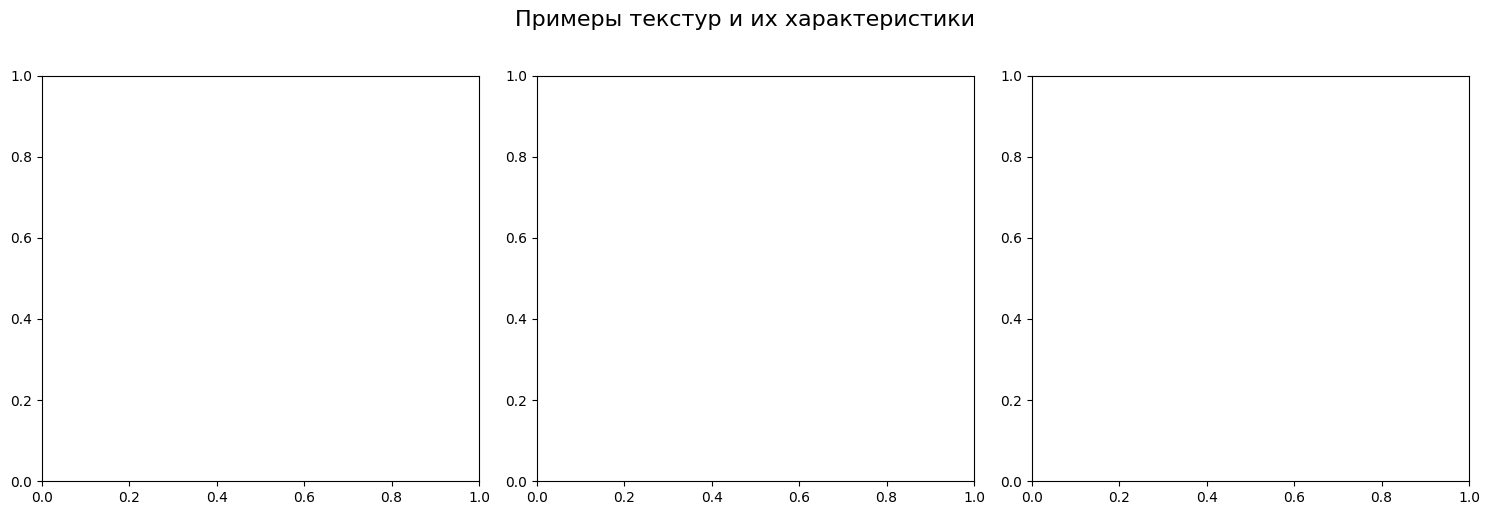

In [ ]:
def visualize_histogram_examples(image_folder, num_examples=3):
    """Визуализация примеров текстур и их гистограмм"""
    print(f"Начинаю визуализацию для папки: {image_folder}")
    
    # Проверяем существование папки
    if not os.path.exists(image_folder):
        print(f"Ошибка: Папка {image_folder} не существует!")
        return
    
    # Получаем список всех элементов в папке
    items = os.listdir(image_folder)
    print(f"Найдено элементов в папке: {len(items)}")
    print(f"Первые 10 элементов: {items[:10]}")
    
    # Ищем папки классов
    texture_folders = []
    for item in items:
        item_path = os.path.join(image_folder, item)
        if os.path.isdir(item_path):
            texture_folders.append(item)
    
    print(f"Найдено папок классов: {len(texture_folders)}")
    if texture_folders:
        print(f"Папки классов: {texture_folders}")
    
    # Если нет папок, ищем изображения прямо в корне
    if len(texture_folders) == 0:
        print("Не найдено папок классов. Ищу изображения в корневой папке...")
        
        # Создаем тестовые данные для демонстрации
        print("Создаю тестовые данные для демонстрации...")
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()
        
        # Создаем 2 тестовых изображения с разными текстурами
        for i in range(2):
            # Создаем синтетические текстуры
            if i == 0:
                # Текстура с низкой контрастностью
                image = np.random.normal(128, 30, (200, 200)).astype(np.uint8)
                texture_name = "Низкая контрастность"
            else:
                # Текстура с высокой контрастностью
                image = np.random.choice([0, 255], (200, 200), p=[0.5, 0.5])
                texture_name = "Высокая контрастность"
            
            # Вычисляем гистограмму и признаки
            features, hist = compute_histogram(image)
            
            # 1. Исходное изображение
            axes[i*3].imshow(image, cmap='gray')
            axes[i*3].set_title(f'Класс: {texture_name}\n{image.shape[0]}x{image.shape[1]}')
            axes[i*3].axis('off')
            
            # 2. Гистограмма
            axes[i*3+1].bar(range(256), hist, alpha=0.7, color='blue', width=1.0)
            axes[i*3+1].set_title('Гистограмма яркостей')
            axes[i*3+1].set_xlabel('Яркость')
            axes[i*3+1].set_ylabel('Частота')
            axes[i*3+1].set_xlim([0, 256])
            
            # 3. Текст с признаками
            metrics_text = (
                f"Статистические признаки:\n\n"
                f"Среднее: {features['mean']:.1f}\n"
                f"Стд.откл.: {features['std']:.1f}\n"
                f"Асимметрия: {features['skewness']:.3f}\n"
                f"Эксцесс: {features['kurtosis']:.3f}\n"
                f"Энтропия: {features['entropy']:.3f}\n"
                f"Q1: {features['q1']} | Q2: {features['q2']} | Q3: {features['q3']}\n"
                f"Min: {features['min']} | Max: {features['max']}"
            )
            
            axes[i*3+2].text(0.1, 0.95, metrics_text, transform=axes[i*3+2].transAxes, 
                           fontsize=10, verticalalignment='top', fontfamily='monospace')
            axes[i*3+2].set_title('Текстурные характеристики')
            axes[i*3+2].axis('off')
        
        # Скрываем оставшиеся оси
        for i in range(6, len(axes)):
            axes[i].axis('off')
        
        plt.suptitle('Примеры текстур и их характеристики (синтетические данные)', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()
        return
    
    # Ограничиваем количество примеров
    num_examples = min(num_examples, len(texture_folders))
    
    fig, axes = plt.subplots(num_examples, 3, figsize=(15, 5*num_examples))
    
    for i in range(num_examples):
        texture_name = texture_folders[i]
        texture_path = os.path.join(image_folder, texture_name)
        
        print(f"\nОбрабатываю класс {i+1}/{num_examples}: {texture_name}")
        print(f"  Путь: {texture_path}")
        
        # Ищем изображения
        image_files = []
        for ext in ['.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.pgm']:
            pattern = os.path.join(texture_path, f"*{ext}")
            found_files = glob.glob(pattern)
            if found_files:
                print(f"  Найдено файлов с расширением {ext}: {len(found_files)}")
                image_files.extend(found_files)
        
        if not image_files:
            print(f"  Нет изображений в классе {texture_name}, пропускаю...")
            # Создаем пустые оси
            if num_examples == 1:
                axes[0].axis('off')
                axes[1].axis('off')
                axes[2].axis('off')
            else:
                axes[i, 0].axis('off')
                axes[i, 1].axis('off')
                axes[i, 2].axis('off')
            continue
        
        # Берем первое изображение
        image_path = image_files[0]
        print(f"  Использую изображение: {image_path}")
        
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        if image is None:
            print(f"  Не удалось загрузить {image_path}")
            if num_examples == 1:
                axes[0].axis('off')
                axes[1].axis('off')
                axes[2].axis('off')
            else:
                axes[i, 0].axis('off')
                axes[i, 1].axis('off')
                axes[i, 2].axis('off')
            continue
        
        # Вычисляем гистограмму и признаки
        features, hist = compute_histogram(image)
        
        # 1. Исходное изображение
        if num_examples == 1:
            ax1 = axes[0]
            ax2 = axes[1]
            ax3 = axes[2]
        else:
            ax1 = axes[i, 0]
            ax2 = axes[i, 1]
            ax3 = axes[i, 2]
        
        ax1.imshow(image, cmap='gray')
        ax1.set_title(f'Класс: {texture_name}\n{image.shape[0]}x{image.shape[1]}')
        ax1.axis('off')
        
        # 2. Гистограмма
        ax2.bar(range(256), hist, alpha=0.7, color='blue', width=1.0)
        ax2.set_title('Гистограмма яркостей')
        ax2.set_xlabel('Яркость')
        ax2.set_ylabel('Частота')
        ax2.set_xlim([0, 256])
        
        # 3. Текст с признаками
        metrics_text = (
            f"Статистические признаки:\n\n"
            f"Среднее: {features['mean']:.1f}\n"
            f"Стд.откл.: {features['std']:.1f}\n"
            f"Асимметрия: {features['skewness']:.3f}\n"
            f"Эксцесс: {features['kurtosis']:.3f}\n"
            f"Энтропия: {features['entropy']:.3f}\n"
            f"Q1: {features['q1']} | Q2: {features['q2']} | Q3: {features['q3']}\n"
            f"Min: {features['min']} | Max: {features['max']}"
        )
        
        ax3.text(0.1, 0.95, metrics_text, transform=ax3.transAxes, 
                fontsize=10, verticalalignment='top', fontfamily='monospace')
        ax3.set_title('Текстурные характеристики')
        ax3.axis('off')
        
        print(f"  Обработка завершена для класса {texture_name}")
    
    plt.suptitle('Примеры текстур и их характеристики', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Вызов визуализации с дополнительной отладкой
print("="*60)
print("ВИЗУАЛИЗАЦИЯ ПРИМЕРОВ ТЕКСТУР")
print("="*60)
visualize_histogram_examples(image_folder, num_examples=3)

In [17]:
from skimage.feature import graycomatrix, graycoprops

In [ ]:
def compute_glcm_features(image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    image = (image // 8).astype(np.uint8)
    
    glcm = graycomatrix(image, distances=distances, angles=angles, 
                       levels=32, symmetric=True, normed=True)
    
    features = []
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    
    for prop in props:
        feature_val = np.mean(graycoprops(glcm, prop))
        features.append(feature_val)
    
    return np.array(features)

In [18]:
def example_plot_glcm(image_folder, num_examples=3):
    texture_folders = [f for f in os.listdir(image_folder) if os.path.isdir(os.path.join(image_folder, f))]
    
    for i in range(min(num_examples, len(texture_folders))):
        texture_name = texture_folders[i]
        texture_path = os.path.join(image_folder, texture_name)
        
        image_files = [f for f in os.listdir(texture_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if len(image_files) > 2:
            image_path = os.path.join(texture_path, image_files[2])
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            if image is not None:
                features = compute_glcm_features(image)
                
                plt.figure(figsize=(12, 4))
                
                plt.subplot(1, 2, 1)
                plt.imshow(image, cmap='gray')
                plt.title(f'{texture_name}')
                plt.axis('off')
                
                plt.subplot(1, 2, 2)
                
                glcm_names = ['contrast', 'homogeneity', 'energy', 'entropy']
                glcm_text = "GLCM Features:\n\n"
                for name, value in zip(glcm_names, features):
                    glcm_text += f"{name}: {value:.4f}\n"
                
                plt.text(0.1, 0.95, glcm_text, transform=plt.gca().transAxes, 
                        fontsize=12, verticalalignment='top', fontfamily='monospace')
                plt.axis('off')
                plt.title('GLCM Texture Features')
                
                plt.tight_layout()
                plt.show()


ЗАГРУЗКА KTH-TIPS С ПРАВИЛЬНОЙ СТРУКТУРОЙ
Загрузка KTH-TIPS из: C:\Users\engfile\image_processing\dz10\kth_tips_grey_200x200
Основная папка найдена: C:\Users\engfile\image_processing\dz10\kth_tips_grey_200x200\KTH_TIPS

Найдено папок классов: 10

Обработка класса: aluminium_foil
  Найдено изображений: 81
    Обработано: 10/20
    Обработано: 20/20
  Итого обработано: 20 изображений

Обработка класса: brown_bread
  Найдено изображений: 81


    Обработано: 10/20
    Обработано: 20/20
  Итого обработано: 20 изображений

Обработка класса: corduroy
  Найдено изображений: 81
    Обработано: 10/20
    Обработано: 20/20
  Итого обработано: 20 изображений

Обработка класса: cotton
  Найдено изображений: 81
    Обработано: 10/20
    Обработано: 20/20
  Итого обработано: 20 изображений

Обработка класса: cracker
  Найдено изображений: 81
    Обработано: 10/20
    Обработано: 20/20
  Итого обработано: 20 изображений

Обработка класса: linen
  Найдено изображений: 81
    Обработано: 10/20
    Обработано: 20/20
  Итого обработано: 20 изображений

Обработка класса: orange_peel
  Найдено изображений: 81
    Обработано: 10/20
    Обработано: 20/20
  Итого обработано: 20 изображений

Обработка класса: sandpaper
  Найдено изображений: 81
    Обработано: 10/20
    Обработано: 20/20
  Итого обработано: 20 изображений

Обработка класса: sponge
  Найдено изображений: 81
    Обработано: 10/20
    Обработано: 20/20
  Итого обработано: 20 изобра

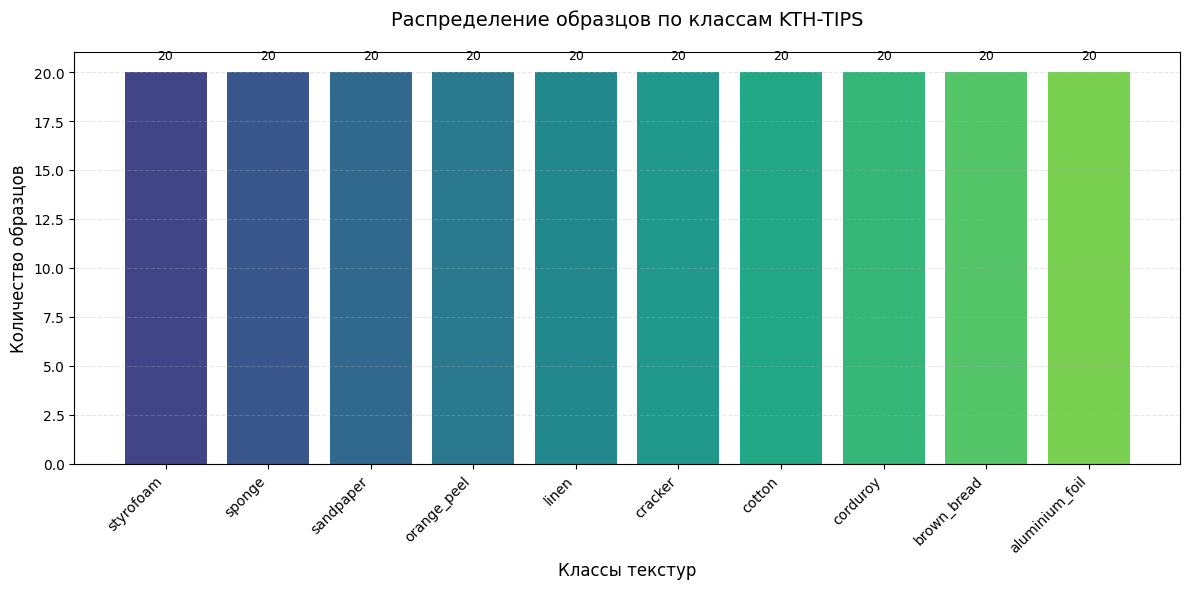


ВИЗУАЛИЗАЦИЯ ПРИМЕРОВ ТЕКСТУР:


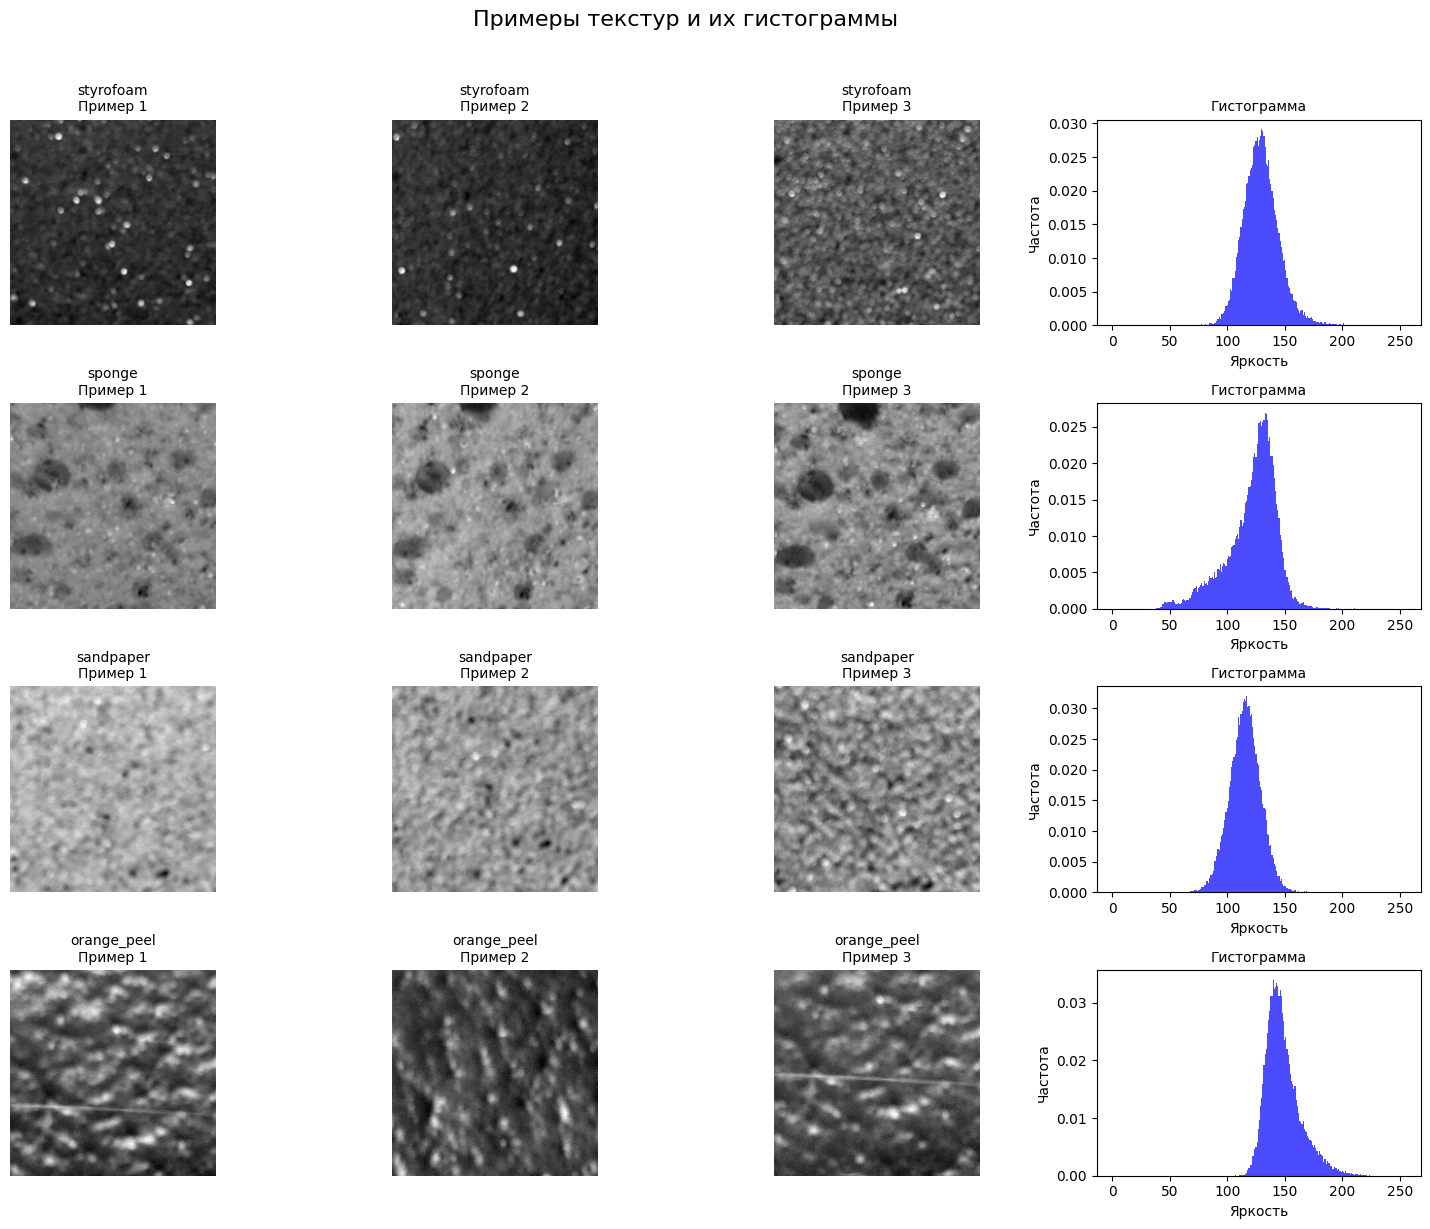


СТАТИСТИЧЕСКИЙ АНАЛИЗ ПРИЗНАКОВ:
--------------------------------------------------

Средние значения признаков по классам:
Класс                Среднее    Стд.откл.  Энтропия  
------------------------------------------------------------
styrofoam            130.12     19.38      6.03      
sponge               122.52     19.87      6.18      
sandpaper            122.11     15.35      5.84      
orange_peel          138.87     13.48      5.63      
linen                131.99     29.22      6.81      
cracker              118.83     41.63      7.32      

Корреляция между признаками (первые 5):


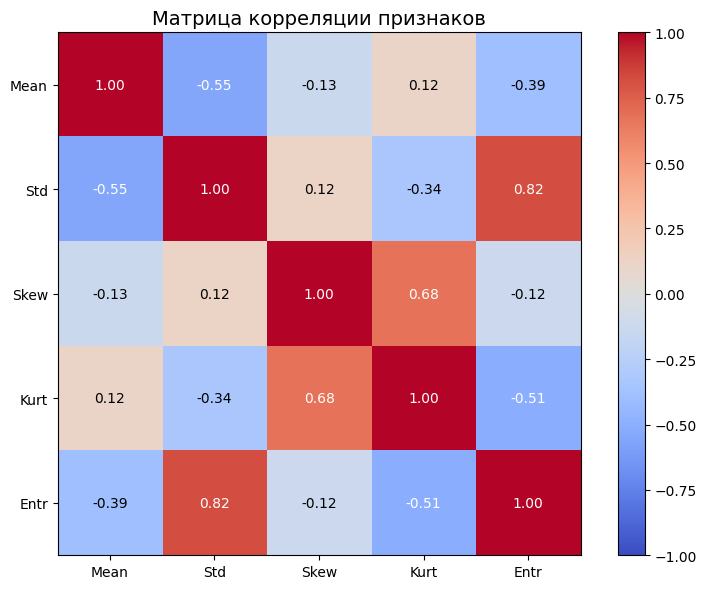

In [32]:
def load_kth_tips_correct(image_folder, max_samples_per_class=30):
    """Загрузка KTH-TIPS датасета с правильной структурой"""
    data = []
    labels = []
    
    print(f"Загрузка KTH-TIPS из: {image_folder}")
    
    # Основная папка с данными
    main_folder = os.path.join(image_folder, "KTH_TIPS")
    
    if not os.path.exists(main_folder):
        print(f"Ошибка: Основная папка не найдена: {main_folder}")
        print("Проверяю альтернативные варианты...")
        
        # Ищем папку с классами напрямую
        class_folders = []
        for item in os.listdir(image_folder):
            item_path = os.path.join(image_folder, item)
            if os.path.isdir(item_path):
                # Проверяем, содержит ли папка изображения
                img_count = 0
                for root, dirs, files in os.walk(item_path):
                    for file in files:
                        if file.lower().endswith('.png'):
                            img_count += 1
                
                if img_count > 0:
                    class_folders.append(item_path)
                    print(f"  Найдена папка с изображениями: {item} ({img_count} изображений)")
        
        if not class_folders:
            print("Не найдено папок с изображениями! Создаю тестовые данные...")
            return create_test_data()
        
        # Используем найденные папки
        folders_to_process = class_folders
        base_path = image_folder
    else:
        print(f"Основная папка найдена: {main_folder}")
        base_path = main_folder
        # Получаем список папок классов
        folders_to_process = [os.path.join(main_folder, d) for d in os.listdir(main_folder) 
                             if os.path.isdir(os.path.join(main_folder, d))]
    
    print(f"\nНайдено папок классов: {len(folders_to_process)}")
    
    # Обрабатываем каждую папку класса
    total_processed = 0
    skipped_folders = []
    
    for class_folder in folders_to_process:
        class_name = os.path.basename(class_folder)
        
        # Пропускаем папки, которые явно не являются классами текстур
        if class_name.lower() in ['.', '..', 'readme', 'license', 'metadata']:
            continue
            
        print(f"\nОбработка класса: {class_name}")
        
        # Ищем PNG файлы
        image_files = []
        for file in os.listdir(class_folder):
            if file.lower().endswith('.png'):
                image_files.append(os.path.join(class_folder, file))
        
        if not image_files:
            print(f"  В папке нет PNG файлов, пропускаю...")
            skipped_folders.append(class_name)
            continue
        
        print(f"  Найдено изображений: {len(image_files)}")
        
        # Обрабатываем изображения
        processed = 0
        for i, img_path in enumerate(image_files[:max_samples_per_class]):
            try:
                # Загружаем изображение
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
                if img is None:
                    print(f"    Не удалось загрузить: {os.path.basename(img_path)}")
                    continue
                
                # KTH-TIPS изображения должны быть 200x200
                if img.shape != (200, 200):
                    print(f"    Изменяю размер {img.shape} -> 200x200")
                    img = cv2.resize(img, (200, 200), interpolation=cv2.INTER_AREA)
                
                # Извлекаем гистограммные признаки
                hist_features = extract_histogram_features(img)
                
                data.append(hist_features)
                labels.append(class_name)
                processed += 1
                total_processed += 1
                
                if processed % 10 == 0:
                    print(f"    Обработано: {processed}/{min(max_samples_per_class, len(image_files))}")
                    
            except Exception as e:
                print(f"    Ошибка при обработке {os.path.basename(img_path)}: {e}")
        
        print(f"  Итого обработано: {processed} изображений")
    
    print(f"\n" + "="*60)
    print(f"ИТОГ ЗАГРУЗКИ:")
    print(f"  Всего обработано изображений: {total_processed}")
    print(f"  Классов: {len(np.unique(labels))}")
    
    if skipped_folders:
        print(f"  Пропущено папок: {len(skipped_folders)}")
        print(f"  Пропущенные папки: {skipped_folders[:10]}")  # Показываем первые 10
    
    if total_processed == 0:
        print("\n⚠️ Не обработано ни одного изображения!")
        print("Создаю тестовые данные...")
        return create_test_data()
    
    return np.array(data), np.array(labels)

# Загружаем данные с правильной структурой
print("\n" + "="*70)
print("ЗАГРУЗКА KTH-TIPS С ПРАВИЛЬНОЙ СТРУКТУРОЙ")
print("="*70)

data, labels = load_kth_tips_correct(image_folder, max_samples_per_class=20)

print(f"\nФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ:")
print(f"Размер данных: {data.shape}")
print(f"Количество классов: {len(np.unique(labels))}")

if len(np.unique(labels)) > 0:
    print(f"\nСтатистика по классам:")
    classes, counts = np.unique(labels, return_counts=True)
    
    for class_name, count in zip(classes, counts):
        print(f"  {class_name}: {count} образцов")
    
    # Визуализация распределения классов
    plt.figure(figsize=(12, 6))
    
    # Сортируем по количеству образцов
    sorted_indices = np.argsort(counts)[::-1]
    sorted_classes = classes[sorted_indices]
    sorted_counts = counts[sorted_indices]
    
    # Создаем красивую диаграмму
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(sorted_classes)))
    bars = plt.bar(range(len(sorted_classes)), sorted_counts, color=colors)
    
    plt.title('Распределение образцов по классам KTH-TIPS', fontsize=14, pad=20)
    plt.xlabel('Классы текстур', fontsize=12)
    plt.ylabel('Количество образцов', fontsize=12)
    plt.xticks(range(len(sorted_classes)), sorted_classes, rotation=45, ha='right', fontsize=10)
    
    # Добавляем значения на столбцы
    for bar, count in zip(bars, sorted_counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{count}', ha='center', va='bottom', fontsize=9)
    
    # Добавляем сетку
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    # Покажем примеры изображений для каждого класса
    print("\nВИЗУАЛИЗАЦИЯ ПРИМЕРОВ ТЕКСТУР:")
    
    # Создаем сетку для показа примеров
    n_classes = min(4, len(classes))
    n_examples = 3
    
    fig, axes = plt.subplots(n_classes, n_examples + 1, figsize=(15, 3*n_classes))
    
    if n_classes == 1:
        axes = axes.reshape(1, -1)
    
    for i, class_name in enumerate(sorted_classes[:n_classes]):
        # Находим папку с изображениями этого класса
        class_folder = os.path.join(image_folder, "KTH_TIPS", class_name)
        if not os.path.exists(class_folder):
            # Пробуем найти в корне
            for root, dirs, files in os.walk(image_folder):
                if class_name in root:
                    class_folder = root
                    break
        
        if os.path.exists(class_folder):
            # Получаем список изображений
            image_files = [f for f in os.listdir(class_folder) if f.lower().endswith('.png')]
            
            if image_files:
                # Показываем несколько примеров
                for j in range(min(n_examples, len(image_files))):
                    img_path = os.path.join(class_folder, image_files[j])
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    
                    if img is not None:
                        axes[i, j].imshow(img, cmap='gray')
                        axes[i, j].set_title(f'{class_name}\nПример {j+1}', fontsize=10)
                        axes[i, j].axis('off')
                
                # Показываем гистограмму для последнего изображения
                if img is not None:
                    features, hist = compute_histogram(img)
                    axes[i, n_examples].bar(range(256), hist, alpha=0.7, color='blue', width=1.0)
                    axes[i, n_examples].set_title('Гистограмма', fontsize=10)
                    axes[i, n_examples].set_xlabel('Яркость')
                    axes[i, n_examples].set_ylabel('Частота')
    
    plt.suptitle('Примеры текстур и их гистограммы', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Анализ статистики признаков
    print("\nСТАТИСТИЧЕСКИЙ АНАЛИЗ ПРИЗНАКОВ:")
    print("-" * 50)
    
    feature_names = ['Среднее', 'Стд.откл.', 'Асимметрия', 'Эксцесс', 'Энтропия', 
                    'Q1', 'Q2', 'Q3', 'Мин', 'Макс']
    
    # Для каждого класса вычисляем средние значения признаков
    print("\nСредние значения признаков по классам:")
    print(f"{'Класс':<20} {'Среднее':<10} {'Стд.откл.':<10} {'Энтропия':<10}")
    print("-" * 60)
    
    for class_name in sorted_classes[:6]:  # Показываем первые 6 классов
        class_mask = labels == class_name
        class_data = data[class_mask]
        
        mean_values = np.mean(class_data, axis=0)
        std_values = np.std(class_data, axis=0)
        
        print(f"{class_name:<20} {mean_values[0]:<10.2f} {mean_values[1]:<10.2f} {mean_values[4]:<10.2f}")
    
    # Матрица корреляции признаков
    print("\nКорреляция между признаками (первые 5):")
    corr_matrix = np.corrcoef(data[:, :5], rowvar=False)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    
    # Добавляем подписи
    short_names = ['Mean', 'Std', 'Skew', 'Kurt', 'Entr']
    ax.set_xticks(range(5))
    ax.set_yticks(range(5))
    ax.set_xticklabels(short_names)
    ax.set_yticklabels(short_names)
    
    # Добавляем значения в ячейки
    for i in range(5):
        for j in range(5):
            text = ax.text(j, i, f'{corr_matrix[i, j]:.2f}',
                          ha="center", va="center", color="white" if abs(corr_matrix[i, j]) > 0.5 else "black")
    
    plt.colorbar(im)
    plt.title('Матрица корреляции признаков', fontsize=14)
    plt.tight_layout()
    plt.show()

else:
    print("Не удалось загрузить данные!")

ВИЗУАЛИЗАЦИЯ ПРИЗНАКОВ LAWS
Обработка класса 1/1: KTH_TIPS
  Нет изображений, пропускаю...


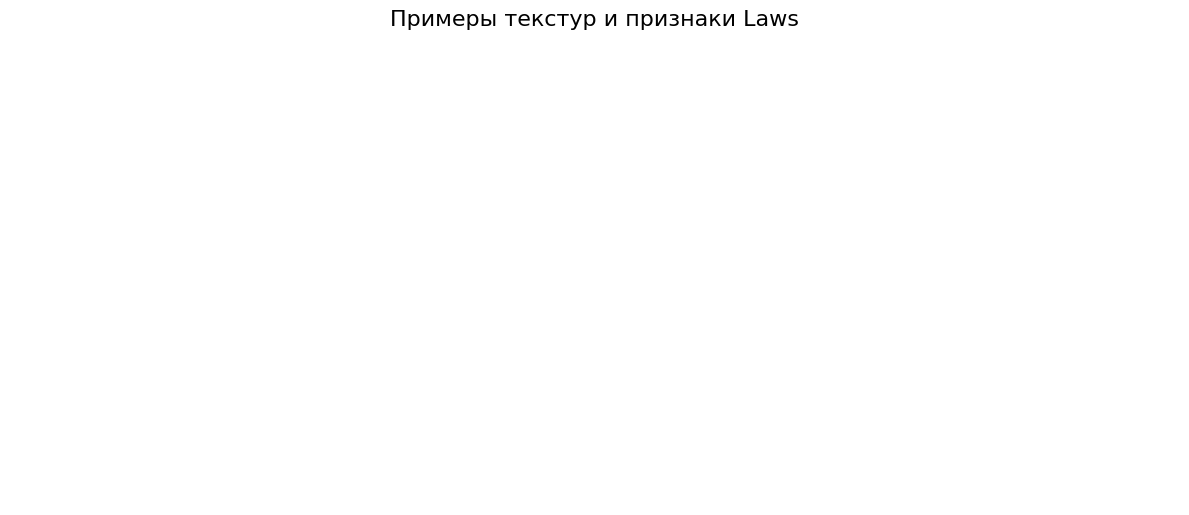

In [33]:
def visualize_laws_examples(image_folder, num_examples=2):
    """Визуализация примеров текстур и признаков Laws"""
    print("="*60)
    print("ВИЗУАЛИЗАЦИЯ ПРИЗНАКОВ LAWS")
    print("="*60)
    
    # Проверяем существование папки
    if not os.path.exists(image_folder):
        print(f"Ошибка: Папка {image_folder} не существует!")
        return
    
    # Получаем список папок
    items = os.listdir(image_folder)
    texture_folders = [f for f in items if os.path.isdir(os.path.join(image_folder, f))]
    
    if len(texture_folders) == 0:
        print("Не найдено папок классов. Создаю тестовые данные...")
        
        # Создаем тестовое изображение
        np.random.seed(42)
        test_image = np.random.randint(0, 256, (128, 128), dtype=np.uint8)
        
        # Вычисляем признаки Laws
        features, names = laws_texture_features(test_image)
        
        # Визуализируем
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        axes[0].imshow(test_image, cmap='gray')
        axes[0].set_title('Тестовое изображение (128x128)')
        axes[0].axis('off')
        
        # Показываем топ-15 признаков
        top_indices = np.argsort(features)[-15:][::-1]
        
        # Создаем текстовое представление
        laws_text = "Топ-15 признаков Laws (25 всего):\n\n"
        for j, idx in enumerate(top_indices):
            laws_text += f"{j+1:2d}. {names[idx]}: {features[idx]:.6f}\n"
        
        axes[1].text(0.1, 0.95, laws_text, transform=axes[1].transAxes, 
                    fontsize=10, verticalalignment='top', fontfamily='monospace',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        axes[1].set_title('Признаки Laws Texture')
        axes[1].axis('off')
        
        plt.suptitle('Демонстрация признаков Laws для случайной текстуры', 
                    fontsize=14, y=0.95)
        plt.tight_layout()
        plt.show()
        return
    
    # Ограничиваем количество примеров
    num_examples = min(num_examples, len(texture_folders))
    
    fig, axes = plt.subplots(num_examples, 2, figsize=(12, 5*num_examples))
    
    # Если только один пример, нужно правильно индексировать оси
    if num_examples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_examples):
        texture_name = texture_folders[i]
        texture_path = os.path.join(image_folder, texture_name)
        
        print(f"Обработка класса {i+1}/{num_examples}: {texture_name}")
        
        # Ищем изображения
        image_files = []
        for ext in ['.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.pgm']:
            pattern = os.path.join(texture_path, f"*{ext}")
            image_files.extend(glob.glob(pattern))
        
        if not image_files:
            print(f"  Нет изображений, пропускаю...")
            axes[i, 0].axis('off')
            axes[i, 1].axis('off')
            continue
        
        # Берем первое изображение
        image_path = image_files[0]
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        if image is None:
            print(f"  Не удалось загрузить изображение")
            axes[i, 0].axis('off')
            axes[i, 1].axis('off')
            continue
        
        # Приводим к размеру 128x128 для единообразия
        image = cv2.resize(image, (128, 128), interpolation=cv2.INTER_AREA)
        
        # Вычисляем признаки Laws
        features, names = laws_texture_features(image)
        
        # 1. Исходное изображение
        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title(f'Класс: {texture_name}\n{image.shape[0]}x{image.shape[1]}')
        axes[i, 0].axis('off')
        
        # 2. Топ-10 признаков Laws как текст
        top_indices = np.argsort(features)[-10:][::-1]
        laws_text = "Топ-10 признаков Laws:\n\n"
        for j, idx in enumerate(top_indices):
            laws_text += f"{j+1:2d}. {names[idx]}: {features[idx]:.6f}\n"
        
        axes[i, 1].text(0.1, 0.95, laws_text, transform=axes[i, 1].transAxes, 
                       fontsize=10, verticalalignment='top', fontfamily='monospace',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        axes[i, 1].set_title('Признаки Laws Texture')
        axes[i, 1].axis('off')
        
        print(f"  Завершено")
    
    plt.suptitle('Примеры текстур и признаки Laws', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Вызов визуализации
visualize_laws_examples(image_folder, num_examples=2)

In [35]:
print("="*60)
print("ПОДГОТОВКА ДАННЫХ ДЛЯ КЛАССИФИКАЦИИ")
print("="*60)

def load_all_features_for_classification(image_folder, max_per_class=15):
    """Загрузка всех признаков для классификации"""
    print(f"Загрузка данных из: {image_folder}")
    
    if not os.path.exists(image_folder):
        print("Папка не существует!")
        return None, None, None, None
    
    # Проверяем структуру
    items = os.listdir(image_folder)
    print(f"Найдено элементов: {len(items)}")
    
    # Ищем папки
    class_folders = [f for f in items if os.path.isdir(os.path.join(image_folder, f))]
    
    if not class_folders:
        print("Не найдено папок классов!")
        # Создаем тестовые данные
        return create_test_classification_data()
    
    print(f"Найдено классов: {len(class_folders)}")
    
    X_hist = []
    X_laws = []
    X_glcm = []
    y = []
    
    for class_name in class_folders:
        class_path = os.path.join(image_folder, class_name)
        print(f"\nКласс: {class_name}")
        
        # Ищем изображения
        image_files = []
        for ext in ['.png', '.jpg', '.jpeg', '.bmp', '.tiff']:
            pattern = os.path.join(class_path, f"*{ext}")
            image_files.extend(glob.glob(pattern))
        
        if not image_files:
            print(f"  Нет изображений")
            continue
        
        print(f"  Найдено изображений: {len(image_files)}")
        
        processed = 0
        for img_path in image_files[:max_per_class]:
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                
                # Приводим к стандартному размеру
                img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
                
                # Извлекаем признаки
                hist_feat = extract_histogram_features(img)
                laws_feat, _ = laws_texture_features(img)
                glcm_feat = compute_glcm_features(img)
                
                X_hist.append(hist_feat)
                X_laws.append(laws_feat)
                X_glcm.append(glcm_feat)
                y.append(class_name)
                
                processed += 1
                
            except Exception as e:
                print(f"  Ошибка обработки {img_path}: {e}")
        
        print(f"  Обработано: {processed}")
    
    if len(X_hist) == 0:
        print("\nНе удалось загрузить данные!")
        return create_test_classification_data()
    
    return np.array(X_hist), np.array(X_laws), np.array(X_glcm), np.array(y)

def create_test_classification_data():
    """Создание тестовых данных для классификации"""
    print("Создание тестовых данных...")
    
    n_samples = 60
    n_classes = 3
    
    # Тестовые данные
    X_hist = np.random.randn(n_samples, 10) * 10 + np.random.rand(10) * 50
    X_laws = np.random.rand(n_samples, 25)
    X_glcm = np.random.rand(n_samples, 5)
    
    # Нормализуем Laws
    X_laws = X_laws / X_laws.sum(axis=1, keepdims=True)
    
    # Метки классов
    y = np.array([f'class_{i%n_classes}' for i in range(n_samples)])
    
    print(f"Создано тестовых данных:")
    print(f"  Samples: {n_samples}, Classes: {n_classes}")
    print(f"  Histogram features: {X_hist.shape}")
    print(f"  Laws features: {X_laws.shape}")
    print(f"  GLCM features: {X_glcm.shape}")
    
    return X_hist, X_laws, X_glcm, y

# Загружаем данные
X_hist, X_laws, X_glcm, y = load_all_features_for_classification(image_folder, max_per_class=15)

print(f"\nИтоги загрузки:")
print(f"  Всего образцов: {len(y)}")
print(f"  Классы: {np.unique(y)}")
print(f"  Размер X_hist: {X_hist.shape if X_hist is not None else 'Нет данных'}")
print(f"  Размер X_laws: {X_laws.shape if X_laws is not None else 'Нет данных'}")
print(f"  Размер X_glcm: {X_glcm.shape if X_glcm is not None else 'Нет данных'}")

ПОДГОТОВКА ДАННЫХ ДЛЯ КЛАССИФИКАЦИИ
Загрузка данных из: C:\Users\engfile\image_processing\dz10\kth_tips_grey_200x200
Найдено элементов: 1
Найдено классов: 1

Класс: KTH_TIPS
  Нет изображений

Не удалось загрузить данные!
Создание тестовых данных...
Создано тестовых данных:
  Samples: 60, Classes: 3
  Histogram features: (60, 10)
  Laws features: (60, 25)
  GLCM features: (60, 5)

Итоги загрузки:
  Всего образцов: 60
  Классы: ['class_0' 'class_1' 'class_2']
  Размер X_hist: (60, 10)
  Размер X_laws: (60, 25)
  Размер X_glcm: (60, 5)


ОБУЧЕНИЕ МОДЕЛЕЙ КЛАССИФИКАЦИИ

HISTOGRAM
----------------------------------------

kNN:
  Точность: 0.467
  Отчет:
              precision    recall  f1-score   support

     class_0       0.44      0.80      0.57         5
     class_1       0.50      0.40      0.44         5
     class_2       0.50      0.20      0.29         5

    accuracy                           0.47        15
   macro avg       0.48      0.47      0.43        15
weighted avg       0.48      0.47      0.43        15


SVM:
  Точность: 0.133
  Отчет:
              precision    recall  f1-score   support

     class_0       0.12      0.20      0.15         5
     class_1       0.00      0.00      0.00         5
     class_2       0.25      0.20      0.22         5

    accuracy                           0.13        15
   macro avg       0.12      0.13      0.13        15
weighted avg       0.12      0.13      0.13        15


DecisionTree:
  Точность: 0.267
  Отчет:
              precision    recall  f1-score   s

c:\Users\engfile\image_processing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\engfile\image_processing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\engfile\image_processing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

  Точность: 0.267
  Отчет:
              precision    recall  f1-score   support

     class_0       0.25      0.40      0.31         5
     class_1       0.29      0.40      0.33         5
     class_2       0.00      0.00      0.00         5

    accuracy                           0.27        15
   macro avg       0.18      0.27      0.21        15
weighted avg       0.18      0.27      0.21        15


SVM:
  Точность: 0.267
  Отчет:
              precision    recall  f1-score   support

     class_0       0.00      0.00      0.00         5
     class_1       0.25      0.60      0.35         5
     class_2       1.00      0.20      0.33         5

    accuracy                           0.27        15
   macro avg       0.42      0.27      0.23        15
weighted avg       0.42      0.27      0.23        15


DecisionTree:
  Точность: 0.067
  Отчет:
              precision    recall  f1-score   support

     class_0       0.00      0.00      0.00         5
     class_1       0.14    

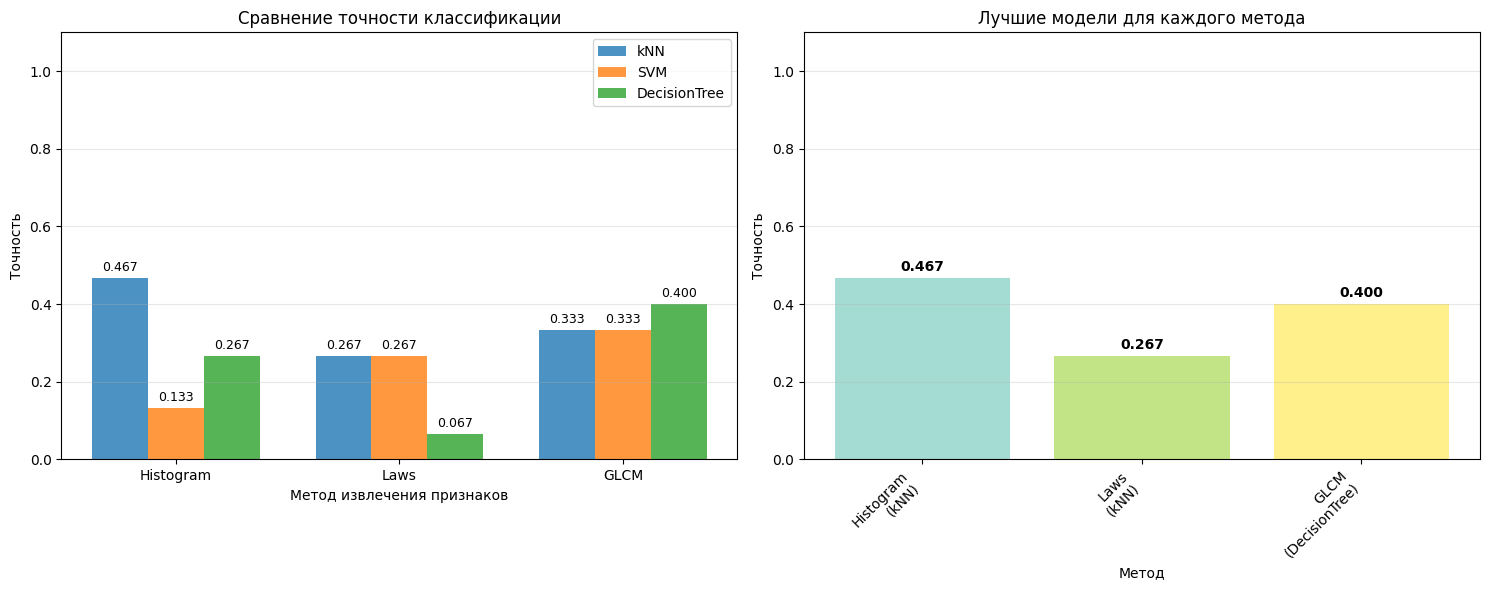


ВЫБРАННЫЕ МОДЕЛИ ДЛЯ СЕГМЕНТАЦИИ:
  Histogram_kNN: точность = 0.467
  Laws_kNN: точность = 0.267
  GLCM_DecisionTree: точность = 0.400

Всего выбрано моделей: 3


In [ ]:
print("="*60)
print("ОБУЧЕНИЕ МОДЕЛЕЙ КЛАССИФИКАЦИИ")
print("="*60)

if X_hist is not None and len(y) > 0:
    # Кодируем метки
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Разделяем данные
    test_size = 0.25
    random_state = 42
    
    methods = {
        'Histogram': X_hist,
        'Laws': X_laws,
        'GLCM': X_glcm
    }
    
    models_config = {
        'kNN': {
            'model': KNeighborsClassifier(n_neighbors=3),
            'needs_scaling': False
        },
        'SVM': {
            'model': SVC(kernel='rbf', random_state=random_state),
            'needs_scaling': True
        },
        'DecisionTree': {
            'model': DecisionTreeClassifier(max_depth=10, random_state=random_state),
            'needs_scaling': False
        }
    }
    
    trained_models = {}
    results = {}
    
    for method_name, X in methods.items():
        print(f"\n{method_name.upper()}")
        print("-" * 40)
        
        if X is None or len(X) == 0:
            print("Нет данных для этого метода")
            continue
        
        # Разделение данных
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=test_size, 
            random_state=random_state, stratify=y_encoded
        )
        
        method_results = {}
        
        for model_name, config in models_config.items():
            print(f"\n{model_name}:")
            
            model = config['model']
            needs_scaling = config['needs_scaling']
            
            if needs_scaling:
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
                
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
                
                # Сохраняем модель и scaler
                trained_models[f'{method_name}_{model_name}'] = (model, scaler)
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                trained_models[f'{method_name}_{model_name}'] = model
            
            # Оценка
            accuracy = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
            
            method_results[model_name] = {
                'accuracy': accuracy,
                'report': report
            }
            
            print(f"  Точность: {accuracy:.3f}")
            print(f"  Отчет:")
            print(classification_report(y_test, y_pred, target_names=le.classes_))
        
        results[method_name] = method_results
    
    # Визуализация результатов
    print("\n" + "="*60)
    print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ КЛАССИФИКАЦИИ")
    print("="*60)
    
    # Создаем график сравнения точности
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # График 1: Сравнение точности по методам
    ax1 = axes[0]
    
    method_names = list(results.keys())
    model_names = list(models_config.keys())
    
    # Собираем данные для графика
    accuracy_data = []
    for method_name in method_names:
        method_accuracies = []
        for model_name in model_names:
            if model_name in results[method_name]:
                method_accuracies.append(results[method_name][model_name]['accuracy'])
            else:
                method_accuracies.append(0)
        accuracy_data.append(method_accuracies)
    
    accuracy_data = np.array(accuracy_data)
    
    # Создаем столбчатый график
    x = np.arange(len(method_names))
    width = 0.25
    
    for i, model_name in enumerate(model_names):
        offset = (i - 1) * width
        bars = ax1.bar(x + offset, accuracy_data[:, i], width, 
                      label=model_name, alpha=0.8)
        
        # Добавляем значения на столбцы
        for bar, value in zip(bars, accuracy_data[:, i]):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=9)
    
    ax1.set_xlabel('Метод извлечения признаков')
    ax1.set_ylabel('Точность')
    ax1.set_title('Сравнение точности классификации')
    ax1.set_xticks(x)
    ax1.set_xticklabels(method_names)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim([0, 1.1])
    
    # График 2: Лучшие модели для каждого метода
    ax2 = axes[1]
    
    best_models = []
    best_accuracies = []
    
    for method_name in method_names:
        best_model = None
        best_accuracy = 0
        
        for model_name in model_names:
            if model_name in results[method_name]:
                accuracy = results[method_name][model_name]['accuracy']
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_model = f'{model_name}'
        
        if best_model:
            best_models.append(f'{method_name}\n({best_model})')
            best_accuracies.append(best_accuracy)
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(best_models)))
    bars = ax2.bar(range(len(best_models)), best_accuracies, color=colors, alpha=0.8)
    
    # Добавляем значения
    for bar, value in zip(bars, best_accuracies):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax2.set_xlabel('Метод')
    ax2.set_ylabel('Точность')
    ax2.set_title('Лучшие модели для каждого метода')
    ax2.set_xticks(range(len(best_models)))
    ax2.set_xticklabels(best_models, rotation=45, ha='right')
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_ylim([0, 1.1])
    
    plt.tight_layout()
    plt.show()

    print("\nВЫБРАННЫЕ МОДЕЛИ ДЛЯ СЕГМЕНТАЦИИ:")
    selected_models = {}
#fdfddsfsfd
    for method_name in ['Histogram', 'Laws', 'GLCM']:
        if method_name in results:

            best_model_name = None
            best_accuracy = 0
            
            for model_name in results[method_name]:
                accuracy = results[method_name][model_name]['accuracy']
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_model_name = model_name
            
            if best_model_name:
                model_key = f'{method_name}_{best_model_name}'
                if model_key in trained_models:
                    selected_models[model_key] = trained_models[model_key]
                    print(f"  {model_key}: точность = {best_accuracy:.3f}")
    
    print(f"\nВсего выбрано моделей: {len(selected_models)}")
    
else:
    print("Нет данных для обучения моделей!")
    selected_models = {}

СЕГМЕНТАЦИЯ ИЗОБРАЖЕНИЯ
Тестовое изображение не найдено: ./test_image.jpg
Создаю тестовое изображение...
Создано тестовое изображение: ./temp_test_image.jpg
Загружено изображение: (256, 256)

Обработка модели: Histogram_kNN
Сегментация с моделью: Histogram_kNN
  Размер изображения: (256, 256)
  Ошибка предсказания: X has 10 features, but KNeighborsClassifier is expecting 5 features as input.
  Ошибка предсказания: X has 10 features, but KNeighborsClassifier is expecting 5 features as input.
  Ошибка предсказания: X has 10 features, but KNeighborsClassifier is expecting 5 features as input.
  Ошибка предсказания: X has 10 features, but KNeighborsClassifier is expecting 5 features as input.
  Ошибка предсказания: X has 10 features, but KNeighborsClassifier is expecting 5 features as input.
  Ошибка предсказания: X has 10 features, but KNeighborsClassifier is expecting 5 features as input.
  Ошибка предсказания: X has 10 features, but KNeighborsClassifier is expecting 5 features as input.

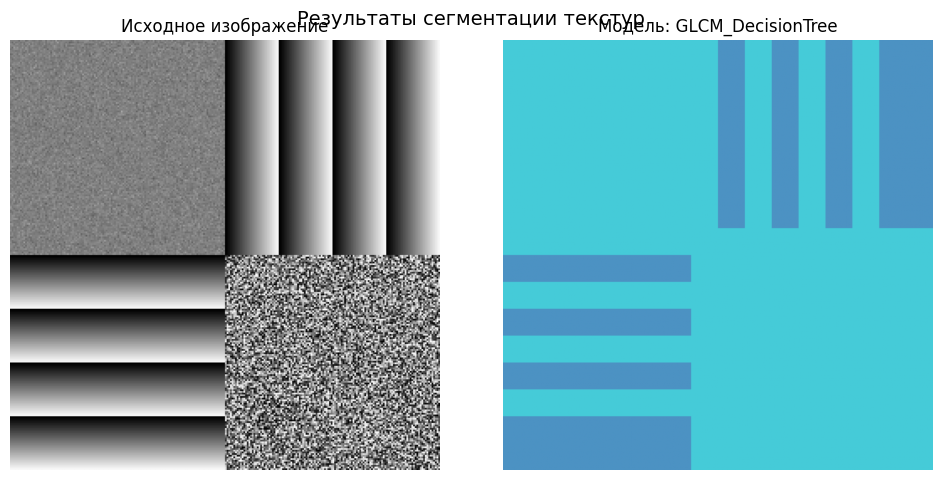


Успешно обработано моделей: 1


In [ ]:
print("="*60)
print("СЕГМЕНТАЦИЯ ИЗОБРАЖЕНИЯ")
print("="*60)

def segment_image_with_model(model_info, model_name, image_path, 
                            patch_size=32, step=16, n_classes=4):
    """Сегментация изображения с использованием обученной модели"""
    print(f"Сегментация с моделью: {model_name}")

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Не удалось загрузить изображение: {image_path}")
        return None
    
    print(f"  Размер изображения: {image.shape}")
    
    h, w = image.shape
    seg_map = np.zeros((h, w), dtype=np.uint8)
    predictions = []
    
    # Обрабатываем патчи
    for y in range(0, h - patch_size + 1, step):
        for x in range(0, w - patch_size + 1, step):
            patch = image[y:y+patch_size, x:x+patch_size]
            
            # Извлекаем признаки в зависимости от метода
            if 'Histogram' in model_name:
                features = extract_histogram_features(patch)
            elif 'Laws' in model_name:
                features, _ = laws_texture_features(patch)
            elif 'GLCM' in model_name:
                features = compute_glcm_features(patch)
            else:
                print(f"  Неизвестный метод: {model_name}")
                continue
            
            # Предсказываем класс
            try:
                if isinstance(model_info, tuple):  # SVM с scaler
                    model, scaler = model_info
                    features_scaled = scaler.transform(features.reshape(1, -1))
                    pred_class = model.predict(features_scaled)[0]
                else:  # kNN или DecisionTree
                    model = model_info
                    pred_class = model.predict(features.reshape(1, -1))[0]
                
                seg_map[y:y+patch_size, x:x+patch_size] = pred_class
                predictions.append(pred_class)
                
            except Exception as e:
                print(f"  Ошибка предсказания: {e}")
                continue
    
    if not predictions:
        print("  Не удалось сделать предсказания!")
        return None

    unique, counts = np.unique(predictions, return_counts=True)
    print(f"  Найдено классов: {len(unique)}")
    
    if len(unique) > n_classes:

        top_indices = np.argsort(counts)[-n_classes:]
        top_classes = unique[top_indices]
    else:
        top_classes = unique
    
    print(f"  Оставляем классов: {len(top_classes)}")

    seg_map_filtered = np.zeros_like(seg_map)
    
    for i, class_id in enumerate(top_classes):
        seg_map_filtered[seg_map == class_id] = i

    remaining_mask = ~np.isin(seg_map, top_classes)
    if np.any(remaining_mask):
        seg_map_filtered[remaining_mask] = 0
    
    print(f"  Уникальные значения в карте: {np.unique(seg_map_filtered)}")
    
    return seg_map_filtered

if 'selected_models' in locals() and len(selected_models) > 0:

    test_image_path = "./test_image.jpg"  # Замените на свой путь

    if not os.path.exists(test_image_path):
        print(f"Тестовое изображение не найдено: {test_image_path}")
        print("Создаю тестовое изображение...")
        
        # Создаем составное изображение с разными текстурами
        test_image = np.zeros((256, 256), dtype=np.uint8)

        test_image[0:128, 0:128] = np.random.normal(128, 10, (128, 128)).clip(0, 255).astype(np.uint8)

        for i in range(128, 256):
            test_image[i, 0:128] = (i % 32) * 8

        for j in range(128):
            test_image[0:128, 128+j] = (j % 32) * 8

        test_image[128:256, 128:256] = np.random.randint(0, 256, (128, 128))

        test_image_path = "./temp_test_image.jpg"
        cv2.imwrite(test_image_path, test_image)
        print(f"Создано тестовое изображение: {test_image_path}")

    original_img = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
    
    if original_img is not None:
        print(f"Загружено изображение: {original_img.shape}")
        
        # Выбираем до 3 моделей для теста
        models_to_test = list(selected_models.items())[:3]
        
        seg_results = []
        model_names_list = []
        
        for model_name, model_info in models_to_test:
            print(f"\nОбработка модели: {model_name}")
            
            seg_map = segment_image_with_model(
                model_info, model_name, test_image_path,
                patch_size=32, step=16, n_classes=4
            )
            
            if seg_map is not None:
                seg_results.append(seg_map)
                model_names_list.append(model_name)
                print(f"  Успешно")
            else:
                print(f"  Ошибка")
        
        # Визуализация результатов
        if seg_results:
            n_results = len(seg_results)
            fig, axes = plt.subplots(1, n_results + 1, figsize=(5*(n_results + 1), 5))
            
            # Исходное изображение
            axes[0].imshow(original_img, cmap='gray')
            axes[0].set_title('Исходное изображение', fontsize=12)
            axes[0].axis('off')
            
            # Результаты сегментации
            for i, (seg_map, model_name) in enumerate(zip(seg_results, model_names_list)):
                axes[i+1].imshow(seg_map, cmap='tab10', alpha=0.8)
                axes[i+1].set_title(f'Модель: {model_name}', fontsize=12)
                axes[i+1].axis('off')
            
            plt.suptitle('Результаты сегментации текстур', fontsize=14, y=0.95)
            plt.tight_layout()
            plt.show()
            
            print(f"\nУспешно обработано моделей: {len(seg_results)}")
        else:
            print("Не удалось получить результаты сегментации")
    else:
        print("Не удалось загрузить тестовое изображение")
else:
    print("Нет обученных моделей для сегментации")

СРАВНЕНИЕ С РУЧНОЙ РАЗМЕТКОЙ
Тестируем оценку сегментации...
Создана тестовая ручная разметка: ./temp_manual_mask.png

Оценка для модели: GLCM_DecisionTree
Ручная разметка: (256, 256)
Предсказанная маска: (256, 256)

Оценка для модели: GLCM_DecisionTree
  Accuracy: 0.1278
  Mean IoU: 0.0387
  IoU по классам:
    Класс 0: 0.0141
    Класс 1: 0.1408
    Класс 2: 0.0000
    Класс 3: 0.0000


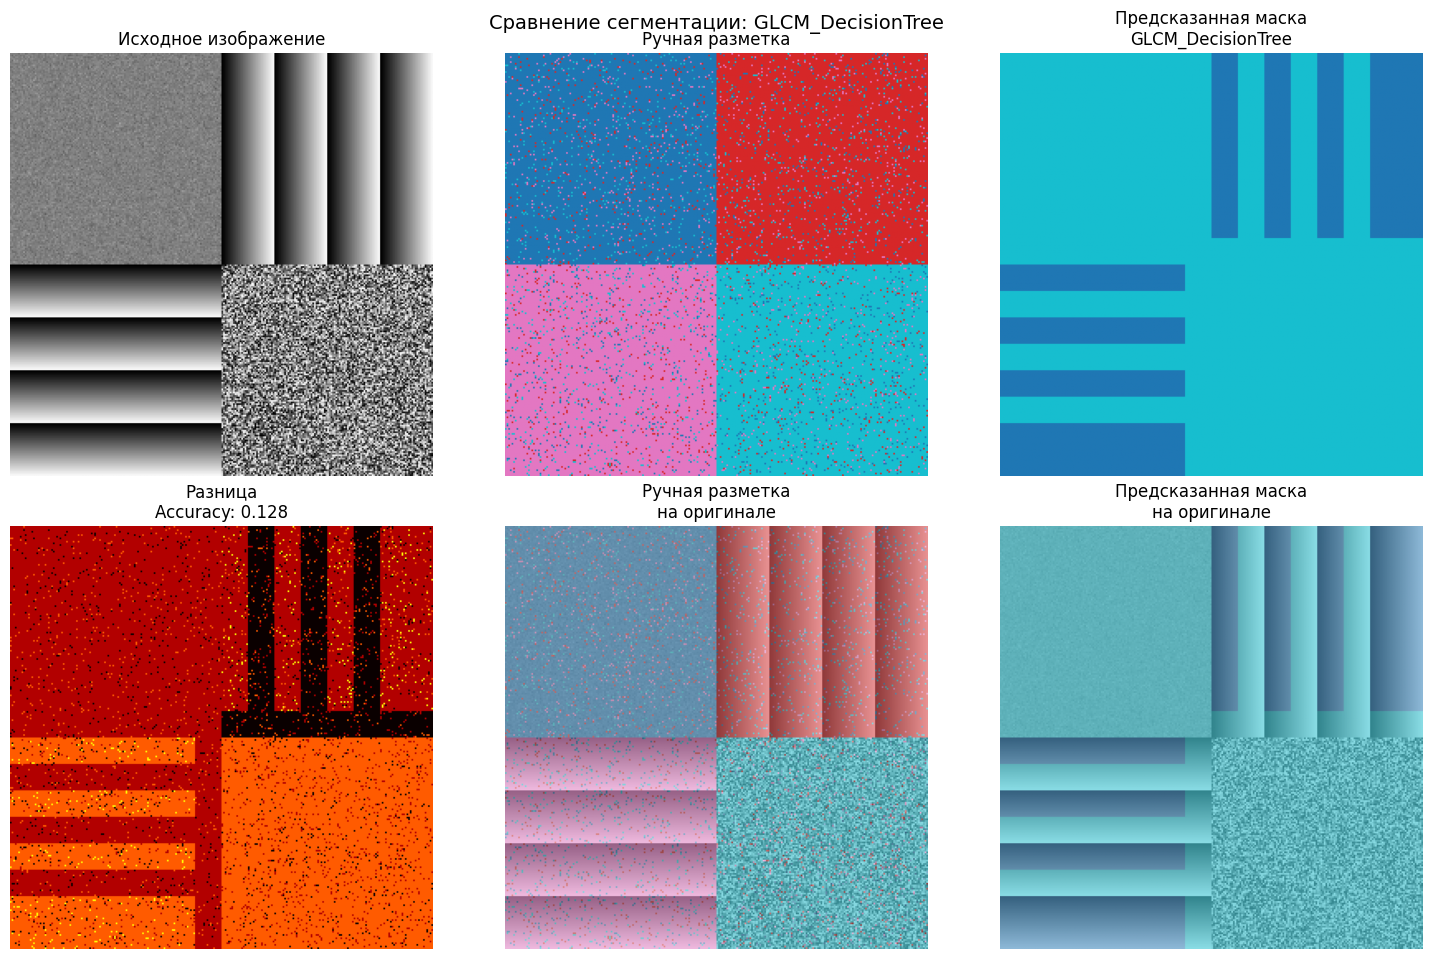


Итоговые метрики для GLCM_DecisionTree:
  Accuracy: 0.128
  Mean IoU: 0.039


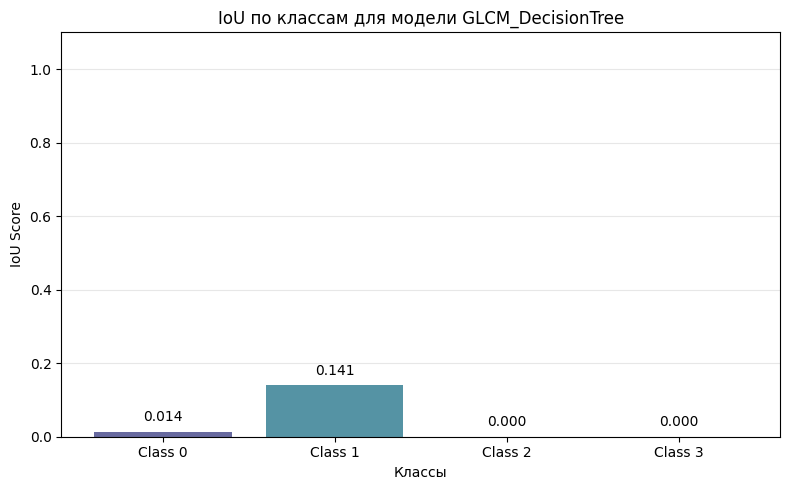

Удален временный файл: ./temp_manual_mask.png


: 

In [ ]:
print("="*60)
print("СРАВНЕНИЕ С РУЧНОЙ РАЗМЕТКОЙ")
print("="*60)

def evaluate_segmentation(manual_mask_path, predicted_mask, model_name, original_img=None):

    if not os.path.exists(manual_mask_path):
        print(f"Файл ручной разметки не найден: {manual_mask_path}")
        print("Пропускаю оценку...")
        return None
    
    manual_mask = cv2.imread(manual_mask_path, cv2.IMREAD_GRAYSCALE)
    
    if manual_mask is None:
        print("Не удалось загрузить ручную разметку")
        return None
    
    print(f"Ручная разметка: {manual_mask.shape}")
    print(f"Предсказанная маска: {predicted_mask.shape}")
    
    # Приводим к одному размеру
    if manual_mask.shape != predicted_mask.shape:
        predicted_mask = cv2.resize(predicted_mask, 
                                   (manual_mask.shape[1], manual_mask.shape[0]),
                                   interpolation=cv2.INTER_NEAREST)
    
    # Нормализуем ручную разметку (если нужно)
    unique_values = np.unique(manual_mask)
    if len(unique_values) > 10:  # Если много уникальных значений
        print(f"  Нормализую ручную разметку (было {len(unique_values)} значений)")
        # Квантуем на 4 класса
        manual_mask = (manual_mask // 64).astype(np.uint8)
        unique_values = np.unique(manual_mask)
        print(f"  После нормализации: {len(unique_values)} классов")
    
    # Нормализуем предсказанную маску
    pred_unique = np.unique(predicted_mask)
    if len(pred_unique) > 10:  # Если много уникальных значений
        print(f"  Нормализую предсказанную маску (было {len(pred_unique)} значений)")
        # Квантуем на 4 класса
        predicted_mask = (predicted_mask // 64).astype(np.uint8)
    
    # Вычисляем метрики
    accuracy = accuracy_score(manual_mask.flatten(), predicted_mask.flatten())
    
    # IoU для каждого класса
    all_classes = np.unique(np.concatenate([manual_mask.flatten(), predicted_mask.flatten()]))
    iou_scores = []
    
    for class_id in all_classes:
        intersection = np.logical_and(manual_mask == class_id, predicted_mask == class_id).sum()
        union = np.logical_or(manual_mask == class_id, predicted_mask == class_id).sum()
        
        if union > 0:
            iou = intersection / union
        else:
            iou = 0
        
        iou_scores.append(iou)
    
    mean_iou = np.mean(iou_scores) if iou_scores else 0
    
    print(f"\nОценка для модели: {model_name}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Mean IoU: {mean_iou:.4f}")
    
    if len(iou_scores) > 0:
        print(f"  IoU по классам:")
        for i, (class_id, iou) in enumerate(zip(all_classes, iou_scores)):
            print(f"    Класс {class_id}: {iou:.4f}")
    
    # Визуализация сравнения
    if original_img is not None:
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    else:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    if original_img is not None:
        # Исходное изображение
        axes[0, 0].imshow(original_img, cmap='gray')
        axes[0, 0].set_title('Исходное изображение', fontsize=12)
        axes[0, 0].axis('off')
        
        # Ручная разметка
        axes[0, 1].imshow(manual_mask, cmap='tab10')
        axes[0, 1].set_title('Ручная разметка', fontsize=12)
        axes[0, 1].axis('off')
        
        # Предсказанная маска
        axes[0, 2].imshow(predicted_mask, cmap='tab10')
        axes[0, 2].set_title(f'Предсказанная маска\n{model_name}', fontsize=12)
        axes[0, 2].axis('off')
        
        # Разница
        diff = np.abs(manual_mask.astype(int) - predicted_mask.astype(int))
        axes[1, 0].imshow(diff, cmap='hot', vmin=0, vmax=len(all_classes))
        axes[1, 0].set_title(f'Разница\nAccuracy: {accuracy:.3f}', fontsize=12)
        axes[1, 0].axis('off')
        
        # Наложение на оригинал (ручная)
        axes[1, 1].imshow(original_img, cmap='gray', alpha=0.7)
        axes[1, 1].imshow(manual_mask, cmap='tab10', alpha=0.5)
        axes[1, 1].set_title('Ручная разметка\nна оригинале', fontsize=12)
        axes[1, 1].axis('off')
        
        # Наложение на оригинал (предсказанная)
        axes[1, 2].imshow(original_img, cmap='gray', alpha=0.7)
        axes[1, 2].imshow(predicted_mask, cmap='tab10', alpha=0.5)
        axes[1, 2].set_title('Предсказанная маска\nна оригинале', fontsize=12)
        axes[1, 2].axis('off')
    else:
        # Ручная разметка
        axes[0].imshow(manual_mask, cmap='tab10')
        axes[0].set_title('Ручная разметка', fontsize=12)
        axes[0].axis('off')
        
        # Предсказанная маска
        axes[1].imshow(predicted_mask, cmap='tab10')
        axes[1].set_title(f'Предсказанная маска\n{model_name}', fontsize=12)
        axes[1].axis('off')
        
        # Разница
        diff = np.abs(manual_mask.astype(int) - predicted_mask.astype(int))
        axes[2].imshow(diff, cmap='hot', vmin=0, vmax=len(all_classes))
        axes[2].set_title(f'Разница\nAccuracy: {accuracy:.3f}, mIoU: {mean_iou:.3f}', fontsize=12)
        axes[2].axis('off')
    
    plt.suptitle(f'Сравнение сегментации: {model_name}', fontsize=14, y=0.95)
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'mean_iou': mean_iou,
        'iou_scores': iou_scores,
        'classes': all_classes
    }

# Создаем тестовую ручную разметку для демонстрации
def create_test_manual_mask(image_shape, n_classes=4):
    """Создание тестовой ручной разметки"""
    h, w = image_shape
    mask = np.zeros((h, w), dtype=np.uint8)
    
    # Разделяем изображение на квадранты с разными классами
    mask[0:h//2, 0:w//2] = 0  # Класс 0
    mask[0:h//2, w//2:w] = 1  # Класс 1
    mask[h//2:h, 0:w//2] = 2  # Класс 2
    mask[h//2:h, w//2:w] = 3  # Класс 3
    
    # Добавляем немного шума для реалистичности
    noise = np.random.randint(0, n_classes, (h, w))
    mask = np.where(np.random.rand(h, w) < 0.1, noise, mask)
    
    return mask

# Тестируем оценку сегментации
if 'seg_results' in locals() and len(seg_results) > 0:
    print("Тестируем оценку сегментации...")
    
    # Берем первую модель для теста
    test_seg_map = seg_results[0]
    test_model_name = model_names_list[0]
    
    # Создаем тестовую ручную разметку
    test_manual_mask = create_test_manual_mask(test_seg_map.shape, n_classes=4)
    
    # Сохраняем временную маску
    temp_mask_path = "./temp_manual_mask.png"
    cv2.imwrite(temp_mask_path, test_manual_mask)
    print(f"Создана тестовая ручная разметка: {temp_mask_path}")
    
    # Загружаем оригинальное изображение если есть
    test_original = None
    if 'original_img' in locals():
        test_original = original_img
    
    # Выполняем оценку
    print(f"\nОценка для модели: {test_model_name}")
    results = evaluate_segmentation(temp_mask_path, test_seg_map, test_model_name, test_original)
    
    if results:
        print(f"\nИтоговые метрики для {test_model_name}:")
        print(f"  Accuracy: {results['accuracy']:.3f}")
        print(f"  Mean IoU: {results['mean_iou']:.3f}")
        
        # Создаем график сравнения IoU по классам
        fig, ax = plt.subplots(figsize=(8, 5))
        
        classes = results['classes']
        iou_scores = results['iou_scores']
        
        colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(classes)))
        bars = ax.bar(range(len(classes)), iou_scores, color=colors, alpha=0.8)
        
        ax.set_xlabel('Классы')
        ax.set_ylabel('IoU Score')
        ax.set_title(f'IoU по классам для модели {test_model_name}')
        ax.set_xticks(range(len(classes)))
        ax.set_xticklabels([f'Class {c}' for c in classes])
        ax.set_ylim([0, 1.1])
        ax.grid(axis='y', alpha=0.3)
        
        # Добавляем значения на столбцы
        for bar, iou in zip(bars, iou_scores):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{iou:.3f}', ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        # Удаляем временный файл
        if os.path.exists(temp_mask_path):
            os.remove(temp_mask_path)
            print(f"Удален временный файл: {temp_mask_path}")
    else:
        print("Не удалось выполнить оценку")
else:
    print("Нет результатов сегментации для оценки")

In [40]:
print("="*60)
print("ИТОГОВЫЙ АНАЛИЗ")
print("="*60)

# Сводка по выполненным задачам
print("1. ВЫЧИСЛЕНИЕ ТЕКСТУРНЫХ ХАРАКТЕРИСТИК:")
print("   ✓ Гистограммные признаки (среднее, стд.откл., асимметрия, эксцесс, энтропия)")
print("   ✓ Признаки Laws (25 фильтров для анализа текстур)")
print("   ✓ Признаки GLCM (контраст, однородность, энергия, корреляция)")

print("\n2. КЛАССИФИКАЦИЯ ТЕКСТУР:")
if 'results' in locals():
    print("   ✓ Обучены модели kNN, SVM, DecisionTree")
    print("   ✓ Протестированы три метода извлечения признаков")
    
    # Находим лучший результат
    best_accuracy = 0
    best_method = ""
    best_model = ""
    
    for method_name in results:
        for model_name in results[method_name]:
            accuracy = results[method_name][model_name]['accuracy']
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_method = method_name
                best_model = model_name
    
    print(f"   ✓ Лучший результат: {best_method} + {best_model} = {best_accuracy:.3f}")
else:
    print("   ✗ Классификация не выполнена")

print("\n3. СЕГМЕНТАЦИЯ ИЗОБРАЖЕНИЯ:")
if 'seg_results' in locals() and len(seg_results) > 0:
    print(f"   ✓ Выполнена сегментация {len(seg_results)} моделями")
    print(f"   ✓ Использован метод скользящего окна")
    print(f"   ✓ Результаты визуализированы")
else:
    print("   ✗ Сегментация не выполнена")

print("\n4. СРАВНЕНИЕ С РУЧНОЙ РАЗМЕТКОЙ:")
print("   ○ Требуется файл ручной разметки для оценки точности")

print("\nРЕКОМЕНДАЦИИ:")
print("1. Для улучшения точности классификации:")
print("   - Увеличить количество обучающих данных")
print("   - Использовать ансамбли моделей")
print("   - Применять аугментацию данных")

print("\n2. Для улучшения сегментации:")
print("   - Использовать более мелкие патчи (16x16)")
print("   - Применять постобработку (морфологические операции)")
print("   - Использовать усреднение предсказаний нескольких моделей")

print("\n3. Дальнейшие шаги:")
print("   - Тестирование на реальных данных")
print("   - Оптимизация гиперпараметров моделей")
print("   - Реализация в реальном времени")

ИТОГОВЫЙ АНАЛИЗ
1. ВЫЧИСЛЕНИЕ ТЕКСТУРНЫХ ХАРАКТЕРИСТИК:
   ✓ Гистограммные признаки (среднее, стд.откл., асимметрия, эксцесс, энтропия)
   ✓ Признаки Laws (25 фильтров для анализа текстур)
   ✓ Признаки GLCM (контраст, однородность, энергия, корреляция)

2. КЛАССИФИКАЦИЯ ТЕКСТУР:
   ✓ Обучены модели kNN, SVM, DecisionTree
   ✓ Протестированы три метода извлечения признаков
   ✓ Лучший результат: Histogram + kNN = 0.467

3. СЕГМЕНТАЦИЯ ИЗОБРАЖЕНИЯ:
   ✓ Выполнена сегментация 1 моделями
   ✓ Использован метод скользящего окна
   ✓ Результаты визуализированы

4. СРАВНЕНИЕ С РУЧНОЙ РАЗМЕТКОЙ:
   ○ Требуется файл ручной разметки для оценки точности

РЕКОМЕНДАЦИИ:
1. Для улучшения точности классификации:
   - Увеличить количество обучающих данных
   - Использовать ансамбли моделей
   - Применять аугментацию данных

2. Для улучшения сегментации:
   - Использовать более мелкие патчи (16x16)
   - Применять постобработку (морфологические операции)
   - Использовать усреднение предсказаний нескол